In [75]:
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup
import re
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import matplotlib.pyplot as plt
import seaborn

seaborn.set(style='ticks')

parser = 'lxml'

separator = re.compile(r'---{3,}')
congress = re.compile(r'((\d{1,3})\w{2}\sCongress)\s\((\d{4})-(\d{4})\)')
majority = re.compile(r'Majority Party.*:\s(.*)\s\((\d*)')
minority = re.compile(r'Minority Party.*:\s(.*)\s\((\d*)')
other = re.compile(r'Other Parties.*:\s(.*)')
total = re.compile(r'Total Seats: (\d{1,3})')

# Quick Visualization - US Senate and House Partisanship over Time

The goal of this notebook is to make a quick visualization of data from the [Senate Party Division](https://www.senate.gov/history/partydiv.htm) page and the [House Party Divisions](http://history.house.gov/Institution/Party-Divisions/Party-Divisions/) page. The data is present on both pages in tabular form, but needs to be scraped. We'll try two methods:
1. `urllib` with `BeautifulSoup`
2. the `pandas.read_html()` method

We'll use the first method on the Senate data and the second for the House.

# Senate Partisanship

## Scraping the data

We'll first need to define two variables to hold the URLs for the data sources. 

In [3]:
senate = 'https://www.senate.gov/history/partydiv.htm'
house = 'http://history.house.gov/Institution/Party-Divisions/Party-Divisions/'

We'll then define four functions: `get_html`, `get_tag`, `break_apart` and `other_party_filter`.
* `get_html` uses the `urllib` library to get the HTML from the Senate webpage and contains basic error handling
* `get_tag` will parse the HTML for the specific HTML tag that we're looking for and let the user know if the tag is missing in the data
* `break_apart` splits the data into individual entries from the HTML table
* `other_party_filter` will extract any third + parties that were present in the data. For example, in the 34th Congress the data includes:
> Other Parties: 1 American Party; 1 Republican

The function will capture the data as a tuple in the form (party, seats)

In [1]:
def get_html(url):
    try:
        return urlopen(url)
    except HTTPError as e:
        print('{} --> {}'.format(e,url))
    except URLError:
        print('Server not found.')
        
def get_tag(tag):
    try:
        if tag is not None:
            return tag
        print('Tag not found!')
    except AttributeError:
        print('Tag not found!')
        
def break_apart(item):
    _final = []
    for element in item:
        if len(element) == 1:
            _final.extend([list(filter(None,i.split('\n'))) for i in element])
        else:
            _final.append(element)
    return _final


def other_party_filter(data):
    _data = []
    for datum in data:
        _datum = []
        if len(datum[0]) != 1:
            for i in datum:
                extract = re.search(r'^\s?(\d{1,3})\s(.+)\s?\(?',i)
                if extract == None:
                    extract = re.search(r'^(\w*)\s\((\d) seat',i)
                extract = sorted(filter(None, [extract.group(1), extract.group(2)]))
                _datum.append((re.sub(r'\s\(.*\)', '',extract[1]).strip(),int(extract[0])))
        else:
            _datum.append(('None', int(datum[0])))
        _data.append(_datum)
    return _data

First we'll get the Senate data and parse it with `BeautifulSoup`. The parser we're using is `lxml`. The parser and the regular expressions are defined in the import cell at the top of the notebook.

In [8]:
senate_html = get_html(senate)
bs_senate = BeautifulSoup(senate_html.read(), parser)

senate_list = '::'.join([i.get_text() for i in get_tag(bs_senate.findAll('p'))])
senate_list = re.split(separator, senate_list)
senate_list = [list(filter(None,i.split('::'))) for i in senate_list]
senate_list = break_apart(senate_list[1:-2])
senate_list[0]

['\n1st Congress (1789-1791)\n',
 'Majority Party: Pro-Administration (18 seats)',
 'Minority Party: Anti-Administration (8 seats)',
 'Other Parties: 0',
 'Total Seats: 26',
 'Note: Organized political parties developed in the U.S. in the 1790s, but political factions--from which organized parties evolved--began to appear almost immediately after establishment of the federal government. Those who supported the Washington administration were referred to as "pro-administration" and would eventually form the Federalist party, while those in opposition joined the emerging (Jeffersonian) Republican party.']

We need to replace the `&nbsp;` in the HTML to continue processing properly. The unicode character that we're looking for is `/xa0`. This analysis was orginally done in Python 2 and then switched to Python 3. The unicode problem is handled automatically in Python 3, so this code is a remnant.

In [5]:
congress_list = [i[0].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
majority_party = [i[1].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
minority_party = [i[2].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
other_party = [i[3].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
total_seats = [i[4].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]

# Sanity check
for each in [congress_list, majority_party, minority_party, other_party, total_seats]:
    assert len(each) == 115

We'll process the data into tuples that are generally of the form `(party, seats)`. We'll also process the tuples into a Pandas DataFrame.

In [9]:
congress_tuples = [(congress.search(i).group(2),congress.search(i).group(1),
                    int(congress.search(i).group(3)),
                    int(congress.search(i).group(4))) for i in congress_list]
minority_tuples = [(minority.search(i).group(1),
                    int(minority.search(i).group(2))) for i in minority_party]
majority_tuples = [(majority.search(i).group(1),
                    int(majority.search(i).group(2))) for i in majority_party]
other_tuples = [other.search(i).group(1) for i in other_party]
other_tuples = other_party_filter([i.split(';') for i in other_tuples])
total_seats = list(map(lambda x: int(x.group(1)) if x != None else None, 
                       [re.search(r'Total Seats: (\d{1,})', i) for i in total_seats]))

df = pd.concat([pd.DataFrame([x[1:] for x in congress_tuples]),
                pd.DataFrame([x for x in majority_tuples]),
               pd.DataFrame([x for x in minority_tuples]),
                pd.DataFrame([x for x in total_seats])], axis=1)
df.columns = ['Congress', 'Start Year', 'End Year', 'Majority Party',
              'Majority Seats', 'Minority Party',
              'Minority Seats', 'Total Seats']
df.set_index('Congress', inplace=True)
df.head()

,Start Year,End Year,Majority Party,Majority Seats,Minority Party,Minority Seats,Total Seats
Congress,,,,,,,
1st Congress,1789,1791,Pro-Administration,18,Anti-Administration,8,26.0
2nd Congress,1791,1793,Pro-Administration,16,Anti-Administration,13,30.0
3rd Congress,1793,1795,Pro-Administration,16,Anti-Administration,14,30.0
4th Congress,1795,1797,Federalist,21,Republican,11,32.0
5th Congress,1797,1799,Federalist,22,Republican,10,32.0


Some values were not processed correctly because there were vacant seats in certain years and those values needed to be added manually. In addition, we'll convert the number of seats to a percentage so that it was comparable as the number of seats changed.

In [18]:
#Fill in Missing Totals Manually
df.set_value('7th Congress','Total Seats', 34)
df.set_value('27th Congress','Total Seats', 52)
df.set_value('56th Congress','Total Seats', 90)
df.set_value('70th Congress','Total Seats', 96)
print(df.loc[["7th Congress",'27th Congress','56th Congress','70th Congress']]["Total Seats"])

df['% Majority'] = df['Majority Seats']/df['Total Seats']*100
df['% Minority'] = df['Minority Seats']/df['Total Seats']*100

df.head()

Congress
7th Congress     34.0
27th Congress    52.0
56th Congress    90.0
70th Congress    96.0
Name: Total Seats, dtype: float64


,Start Year,End Year,Majority Party,Majority Seats,Minority Party,Minority Seats,Total Seats,% Majority,% Minority
Congress,,,,,,,,,
1st Congress,1789,1791,Pro-Administration,18,Anti-Administration,8,26.0,69.230769,30.769231
2nd Congress,1791,1793,Pro-Administration,16,Anti-Administration,13,30.0,53.333333,43.333333
3rd Congress,1793,1795,Pro-Administration,16,Anti-Administration,14,30.0,53.333333,46.666667
4th Congress,1795,1797,Federalist,21,Republican,11,32.0,65.625000,34.375000
5th Congress,1797,1799,Federalist,22,Republican,10,32.0,68.750000,31.250000


### Plotting the data
Let's plot the % Majority and Minority data versus the Year.

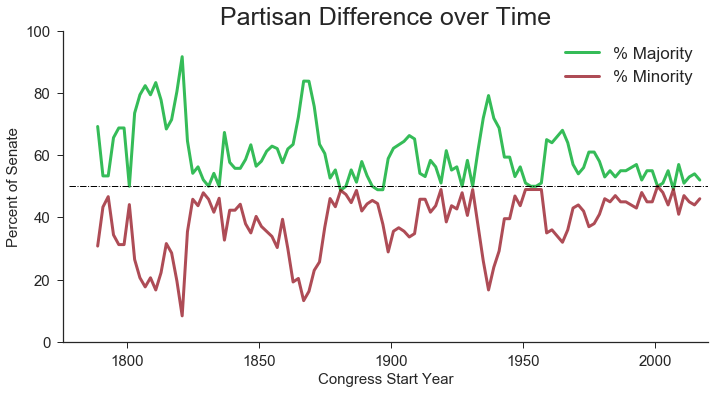

In [123]:
plt.figure(figsize=(7, 5),dpi=300)
fg = seaborn.FacetGrid(data=df[['% Majority','% Minority','Start Year']],
                    size=5, aspect=2, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.plot, 'Start Year', '% Majority',
       alpha =0.8, linewidth='3', 
       color='xkcd:kelly green', label='% Majority')
fg.map(plt.plot, 'Start Year', '% Minority',
       alpha =0.7, linewidth='3',
       color='xkcd:crimson', label='% Minority')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
plt.ylabel('Percent of Senate', fontsize=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('Congress Start Year', fontsize=15)
plt.legend(fontsize=17)
plt.subplots_adjust(top=1.0)
plt.title('Partisan Difference over Time', fontsize=25)

The plot doesn't show much that's useful to us, but it does show us that the fluctuations from one party to another appear to have decreased in magnitude. We should plot the difference between the majority and minority parties over time. If we define the partisan difference as majority percentage - minority percentage, we can guarantee a positive answer. The color was chosen by subtracting `xkcd:crimson` (#8c000f) from `xkcd:kelly green` (#02ab2e) using [ColorHexa](http://www.colorhexa.com/), the same way we defined partisan difference.

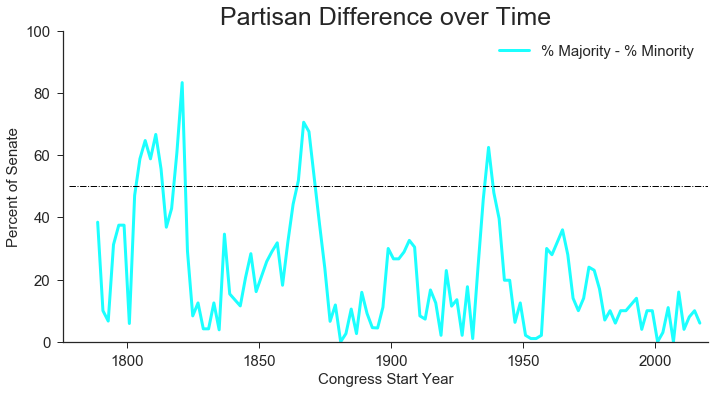

In [124]:
df['Partisan Difference'] = df['% Majority'] - df['% Minority']

plt.figure(figsize=(7, 5),dpi=300)
seaborn.set_palette(seaborn.color_palette("tab20b", 8))
fg = seaborn.FacetGrid(data=df[['Partisan Difference','Start Year']],
                    size=5, aspect=2, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.plot, 'Start Year', 'Partisan Difference',
       alpha =0.9,linewidth='3',
       color='#03ffff', label='% Majority - % Minority')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
plt.yticks(size=15)
plt.ylabel('Percent of Senate', fontsize=15)
plt.xticks(size=15)
plt.xlabel('Congress Start Year', fontsize=15)
plt.legend(fontsize=15)
plt.subplots_adjust(top=1.0)
plt.title('Partisan Difference over Time', fontsize=25)

## Splitting the 

In [21]:
df.head()

,Start Year,End Year,Majority Party,Majority Seats,Minority Party,Minority Seats,Total Seats,% Majority,% Minority,Partisan Difference
Congress,,,,,,,,,,
1st Congress,1789,1791,Pro-Administration,18,Anti-Administration,8,26.0,69.230769,30.769231,38.461538
2nd Congress,1791,1793,Pro-Administration,16,Anti-Administration,13,30.0,53.333333,43.333333,10.000000
3rd Congress,1793,1795,Pro-Administration,16,Anti-Administration,14,30.0,53.333333,46.666667,6.666667
4th Congress,1795,1797,Federalist,21,Republican,11,32.0,65.625000,34.375000,31.250000
5th Congress,1797,1799,Federalist,22,Republican,10,32.0,68.750000,31.250000,37.500000


In [12]:
df_majority = df[['Majority Party', '% Majority', 'Start Year', 'End Year']].copy()
df_minority = df[['Minority Party', '% Minority', 'Start Year', 'End Year']].copy()

df_majority['Congress'] = df_majority.index
df_majority.rename(columns = {'Majority Party':'Party', '% Majority': 'Percent'}, inplace=True)

df_minority['Congress'] = df_minority.index
df_minority.rename(columns = {'Minority Party':'Party', '% Minority': 'Percent'}, inplace=True)
df_minority.head()

,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Anti-Administration,30.769231,1789,1791,1st Congress
2nd Congress,Anti-Administration,43.333333,1791,1793,2nd Congress
3rd Congress,Anti-Administration,46.666667,1793,1795,3rd Congress
4th Congress,Republican,34.375000,1795,1797,4th Congress
5th Congress,Republican,31.250000,1797,1799,5th Congress


In [13]:
df_majority.head()

,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Pro-Administration,69.230769,1789,1791,1st Congress
2nd Congress,Pro-Administration,53.333333,1791,1793,2nd Congress
3rd Congress,Pro-Administration,53.333333,1793,1795,3rd Congress
4th Congress,Federalist,65.625000,1795,1797,4th Congress
5th Congress,Federalist,68.750000,1797,1799,5th Congress


In [14]:
parties = df_majority.append(df_minority)
group_parties = parties.groupby(by=parties['Party'])
parties.sort_values(by='Start Year', inplace=True)

In [15]:
parties['Party'].unique()

array(['Pro-Administration', 'Anti-Administration', 'Federalist',
       'Republican', 'Adams-Clay Republicans & Federalists',
       'Jackson & Crawford Republicans', 'Adams', 'Jacksonian',
       'Anti-Jackson', 'Whig', 'Democrat', 'Opposition'], dtype=object)

In [16]:
parties.head()

,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Pro-Administration,69.230769,1789,1791,1st Congress
1st Congress,Anti-Administration,30.769231,1789,1791,1st Congress
2nd Congress,Pro-Administration,53.333333,1791,1793,2nd Congress
2nd Congress,Anti-Administration,43.333333,1791,1793,2nd Congress
3rd Congress,Pro-Administration,53.333333,1793,1795,3rd Congress


In [20]:
_parties = sorted(['Pro-Administration', 'Federalist', 'Republican', 'Jackson & Crawford Republicans', 'Jacksonian',
            'Anti-Jackson', 'Democrat', 'Whig', 'Anti-Administration', 'Adams-Clay Republicans & Federalists',
            'Adams', 'Opposition'])

In [125]:
seaborn.set_context("poster")
plt.figure(figsize=(20, 14),dpi=1200)
seaborn.set_palette(seaborn.color_palette("tab20b", len(_parties)))
fg = seaborn.FacetGrid(data=parties, hue='Party', hue_order=_parties,
                    size=7, aspect=3, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Percent', alpha =0.9, facecolors='none',linewidth='3')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
fg.add_legend()

NameError: name '_parties' is not defined

In [44]:
_markers = [x for x in '‘.,ov^<>8spP*h+xD']

In [ ]:
_party_marker

In [ ]:
_colors = seaborn.color_palette(
    'tab20b',
    len(_parties)
                                )
_party_color = {k: v for (k,v) in zip(_parties, _colors ,)}
_party_marker = {k: v for (k,v) in zip(_parties, _markers ,)}

fig, ax = plt.subplots(figsize=(30,15), dpi=600)
for party in _parties:
    x, y = parties[parties['Party'] == party]['Start Year'],\
            parties[parties['Party'] == party]['Percent']
    ax.scatter(x, y, c=_party_color[party], s = 200,
               label=party, alpha=0.9, marker=_party_marker[party])


labelsize = 33
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot([1776, 2020], [50, 50], 'k-.', lw=2.5)
plt.tick_params(axis='both', which='major', labelsize=0.8*labelsize)
plt.title('Percentage of Senate by Party', fontsize=1.5*labelsize, fontweight='bold')
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Percentage (%)', fontsize=labelsize)
plt.axis([1776, 2020, 0, 100])
plt.show()

ValueError: Unrecognized marker style ‘

# House Partisanship

In [18]:
header=['Congress (Years)',
            '# of House Seats',
            'Party A',
            'Party B',
            'Other',
            'Delegates/Representatives']

house_table = pd.read_html(house)
house_table = house_table[0]

header.extend([x for x in house_table.columns if x not in header])
house_table['Delegates/Representatives'] = house_table['Del./Res.']
house_table = house_table.reindex(columns = header)
house_table.drop('Del./Res.', axis=1, inplace=True)

house_table.set_value(97,'# of House Seats', 436)

house_table.head()

,Congress (Years),# of House Seats,Party A,Party B,Other,Delegates/Representatives,Pro-Administration,Anti-Administration
0,1st (1789-1791),65,NaN,NaN,0,0/0,37,28
1,2nd (1791-1793),69,NaN,NaN,0,0/0,39,30
2,3rd (1793-1795),105,NaN,NaN,0,1/0,51,54
3,Congress (Years),# of House Seats,NaN,NaN,Other,Del./Res.,Federalists,Jeffersonian Republicans
4,4th (1795-1797),106,NaN,NaN,0,1/0,47,59


In [19]:
label_indicies = house_table.loc[house_table['Congress (Years)'] == 'Congress (Years)'].index

for i in range(len(label_indicies)-1):
    if i == len(label_indicies)-2:
        house_table.loc[range(label_indicies[i]+1,len(house_table)),'Party A'] = \
            house_table.iloc[label_indicies[i]]['Pro-Administration']
        house_table.loc[range(label_indicies[i]+1,len(house_table)),'Party B'] = \
            house_table.iloc[label_indicies[i]]['Anti-Administration']
    else:
        house_table.loc[range(label_indicies[i]+1,label_indicies[i+1]),'Party A'] = \
            house_table.iloc[label_indicies[i]]['Pro-Administration']
        house_table.loc[range(label_indicies[i]+1,label_indicies[i+1]),'Party B'] = \
                house_table.iloc[label_indicies[i]]['Anti-Administration']
        
house_table.loc[range(label_indicies[0]),'Party A'] = 'Pro-Administration'
house_table.loc[range(label_indicies[0]),'Party B'] = 'Anti-Administration'

house_table.drop(house_table.index[label_indicies], inplace=True)

house_table.rename(columns={'Pro-Administration': 'Party A Seats',
                            'Anti-Administration': 'Party B Seats'}, inplace=True)

house_table['Party A %'] = house_table['Party A Seats'].astype('int')\
                                /house_table['# of House Seats'].astype('int') * 100
house_table['Party B %'] = house_table['Party B Seats'].astype('int') \
                                /house_table['# of House Seats'].astype('int') * 100

In [20]:
year_extract = re.compile(r'\d+(st|nd|rd|th) \((?P<Start_Year>\d{4}).(?P<End_Year>\d{4})\)')

house_table = pd.concat(
    [house_table,
    house_table['Congress (Years)'].str.extract(
        year_extract, expand=True)[['Start_Year','End_Year']]],
    axis=1
                        )
house_table.rename(columns={'Start_Year': 'Start Year',
                            'End_Year': 'End Year'}, inplace=True)

house_table.head()

,Congress (Years),# of House Seats,Party A,Party B,Other,Delegates/Representatives,Party A Seats,Party B Seats,Party A %,Party B %,Start Year,End Year
0,1st (1789-1791),65,Pro-Administration,Anti-Administration,0,0/0,37,28,56.923077,43.076923,1789,1791
1,2nd (1791-1793),69,Pro-Administration,Anti-Administration,0,0/0,39,30,56.521739,43.478261,1791,1793
2,3rd (1793-1795),105,Pro-Administration,Anti-Administration,0,1/0,51,54,48.571429,51.428571,1793,1795
4,4th (1795-1797),106,Federalists,Jeffersonian Republicans,0,1/0,47,59,44.339623,55.660377,1795,1797
5,5th (1797-1799),106,Federalists,Jeffersonian Republicans,0,0/0,57,49,53.773585,46.226415,1797,1799


In [21]:
cols = list(house_table.columns)
[cols.remove(x) for x in cols if x.startswith('Party A')]
house_partyB = house_table[cols].copy()
house_partyB.rename(
    columns={x:re.sub(r' [AB]','',x) for x in house_partyB.columns if x.startswith('Party')},
    inplace=True)

cols = list(house_table.columns)
[cols.remove(x) for x in cols if x.startswith('Party B')]
house_partyA = house_table[cols].copy()
house_partyA.rename(
    columns={x:re.sub(r' [AB]','',x) for x in house_partyA.columns if x.startswith('Party')},
    inplace=True)

house_data = pd.concat([house_partyA, house_partyB])
house_data

,Congress (Years),# of House Seats,Party,Other,Delegates/Representatives,Party Seats,Party %,Start Year,End Year
0,1st (1789-1791),65,Pro-Administration,0,0/0,37,56.923077,1789,1791
1,2nd (1791-1793),69,Pro-Administration,0,0/0,39,56.521739,1791,1793
2,3rd (1793-1795),105,Pro-Administration,0,1/0,51,48.571429,1793,1795
4,4th (1795-1797),106,Federalists,0,1/0,47,44.339623,1795,1797
5,5th (1797-1799),106,Federalists,0,0/0,57,53.773585,1797,1799
6,6th (1799-1801),106,Federalists,0,1/0,60,56.603774,1799,1801
7,7th (1801-1803),106,Federalists,0,2/0,38,35.849057,1801,1803
8,8th (1803-1805),142,Federalists,0,1/0,39,27.464789,1803,1805
9,9th (1805-1807),142,Federalists,0,3/0,28,19.718310,1805,1807
10,10th (1807-1809),142,Federalists,0,3/0,26,18.309859,1807,1809


In [22]:
_house_parties = list(house_table['Party A'].unique())
_house_parties.extend(house_table['Party B'].unique())

In [ ]:
seaborn.set_context("poster")
plt.figure(figsize=(20, 14),dpi=1200)
seaborn.set_palette(seaborn.color_palette("tab20b", len(_house_parties)))
fg = seaborn.FacetGrid(
    data=house_data, 
    hue='Party',
    hue_order=_house_parties,
    size=7, aspect=3, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Party %', alpha =0.65)
fg.title('US House of Representatives Partisanship by Year')
fg.add_legend()

In [27]:
_colors = seaborn.color_palette("husl", len(_house_parties))
_party_color = {k: v for (k,v) in zip(_house_parties, _colors ,)}

fig, ax = plt.subplots(figsize=(40,20), dpi=600)
for party in _house_parties:
    x = house_data[house_data['Party'] == party]['Start Year']
    y = house_data[house_data['Party'] == party]['Party %']
    ax.scatter(x, y, c=_party_color[party], s = 200, 
               label=party, alpha=0.9, edgecolors='none')


labelsize = 33
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot([1778, 2020], [50, 50], 'k-.', lw=2.5)
plt.tick_params(axis='both', which='major', labelsize=0.8*labelsize)
plt.title('Percentage of House by Party', fontsize=1.5*labelsize, fontweight='bold')
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Percentage (%)', fontsize=labelsize)
plt.axis([1788, 2020, 0, 100])
plt.show()